## Summary

Author: Yi Li

__Data Source:__ The raw lending club loan data is downloaded from the website [Lending Club Statistics](https://www.lendingclub.com/info/download-data.action).

__Project Purpose:__ This project trys to predict whether a user is going to default on his or her loan. This is meaningful, because if we can predict and target these people, we can take actions earlier and reduce the default rate of a company.

__Method & Results:__ After lots of data exploration, data cleaning and feature enginerring, I extracted 60+ features (110+ features after one-hot encoding for categorical features) from the original 150+ features. I defined the target "default" as any user whose loan status is past due (not "Current" and not "Fully Paid"). I split the cleaned dataset as a training dataset (70%) and a test dataset (30%).

I used two models: 

    (a) a logistic classifier with regularization (Lasso) to control multilinear problem 
    Training auc-score:99.4%, test auc-score: 99.4%,
    Training accuracy: 98.2%, test accuracy: 98.3% (threshold = 0.5). 
    
    Top features: 'pymnt_plan','last_credit_pull_d_since_issue','log_loan_amnt','disbursement_method','term','new_zip'(collapsed from the orginal feature 'zip_code'),'purpose','pub_rec_bankruptcies'
    
 
    (b) a random forest classifier
    Training auc-score:99.9%, test auc-score: 99.6%,
    Training accuracy: 98.8%, test accuracy: 98.4% (threshold = 0.5).

    Top features: 
    'next_pymnt_d_since_issue','last_pymnt_d_since_issue','out_prncp','last_pymnt_amnt','last_credit_pull_d_since_issue','total_rec_prncp','last_fico_range_low','total_rec_int','total_pymnt','collection_recovery_fee'
    

    
__Conclusion__: Generally speaking, the results of model (b) is better than model (a).

The top features achieved from two models are very different. They only share one common feature 'last_credit_pull_d_since_issue' (the number of days from last time pull credit since issue). Other important features including 'pymnt_plan' (which is "yes" or "no"), 'log_loan_amnt' (the log of loan amount), 'disbursement_method' (cash or directed pay), 'term'(36 or 60 months), 'next_pymnt_d_since_issue', 'last_pymnt_d_since_issue', 'out_prncp'(remaining outstanding principal for total amount funded), 'last_pymnt_amnt'.
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# load the data from https://www.lendingclub.com/info/download-data.action
loan =  pd.read_csv('LoanStats_securev1_2016Q1.csv', skiprows=1, skipfooter=2)
loan.shape

/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


(133887, 151)

In [3]:
loan.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,76003542,NaN,16000,16000,16000.0,36 months,5.32%,481.84,A,A1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,76023477,NaN,17000,17000,17000.0,36 months,9.75%,546.55,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
## Meaning of loan status
# Completed or fully paid: All paid off
# Current: All past payments on time and as agreed, not fully paid off yet.
# In grace period: Loan is past due but within the 15-day grace period.
# Default: 121+ days past due.
# Charged off: 150 days past due
loan['loan_status'].value_counts(), loan['loan_status'].isnull().sum()

(Current               79931
 Fully Paid            35650
 Charged Off           13043
 Late (31-120 days)     3157
 In Grace Period        1637
 Late (16-30 days)       458
 Default                  11
 Name: loan_status, dtype: int64, 0)

### Exploration some dates related variables

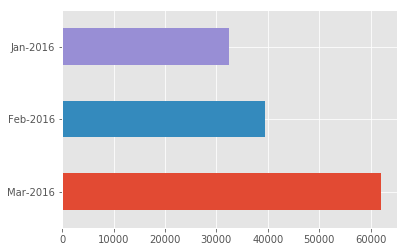

In [5]:
loan['issue_d'].value_counts().plot.barh()

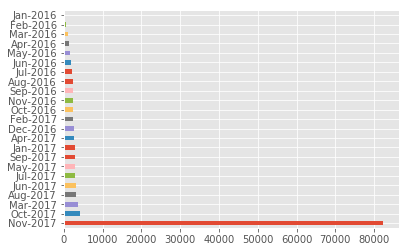

In [6]:
loan['last_pymnt_d'].value_counts().plot.barh()

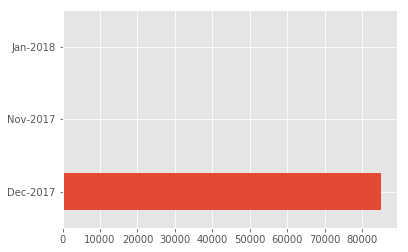

In [7]:
loan['next_pymnt_d'].value_counts().plot.barh()

In [8]:
loan.groupby(['loan_status', loan['next_pymnt_d'].isnull(), 
              loan['last_pymnt_d'].isnull()]).size()

loan_status         next_pymnt_d  last_pymnt_d
Charged Off         True          False           12895
                                  True              148
Current             False         False           79931
Default             False         False              11
Fully Paid          True          False           35650
In Grace Period     False         False            1637
Late (16-30 days)   False         False             458
Late (31-120 days)  False         False            3157
dtype: int64

If it is fully paid, the "next payment day" is nan.

If it is charged off, the "next payment day" is nan, the "last payment day" is nan or not nan.

## Data Cleaning & Feature Engineering

### Update features to reflect loan is jointly applied

In [9]:
loan['dti'] = np.where(loan['dti_joint'] > 0, loan['dti_joint'], loan['dti'])

loan['annual_inc'] = np.where(loan['annual_inc_joint'] > 0, 
                              loan['annual_inc_joint'], 
                              loan['annual_inc'])

loan['verification_status'] = np.where(loan['verification_status_joint'].notnull(), 
                                       loan['verification_status_joint'], 
                                       loan['verification_status'])

loan.drop(['dti_joint', 'annual_inc_joint', 'verification_status_joint'], axis=1, inplace=True)

print(loan['application_type'].unique())
loan.drop(['application_type'], axis=1,inplace=True)
loan.shape

['Individual' 'Joint App']


(133887, 147)

### Clean data - remove unnessary features

In [10]:
# Remove features with all NaN value
#loan.isnull().sum(axis=0)
sorted([(loan[loan.columns[i]].isnull().sum(), loan.columns[i]) for i in 
        range(len(loan.columns))], reverse=True)[:17]

[(133887, 'sec_app_revol_util'),
 (133887, 'sec_app_open_act_il'),
 (133887, 'sec_app_open_acc'),
 (133887, 'sec_app_num_rev_accts'),
 (133887, 'sec_app_mths_since_last_major_derog'),
 (133887, 'sec_app_mort_acc'),
 (133887, 'sec_app_inq_last_6mths'),
 (133887, 'sec_app_fico_range_low'),
 (133887, 'sec_app_fico_range_high'),
 (133887, 'sec_app_earliest_cr_line'),
 (133887, 'sec_app_collections_12_mths_ex_med'),
 (133887, 'sec_app_chargeoff_within_12_mths'),
 (133887, 'revol_bal_joint'),
 (133887, 'member_id'),
 (133877, 'desc'),
 (133252, 'orig_projected_additional_accrued_interest'),
 (133113, 'payment_plan_start_date')]

In [11]:
loan = loan.drop(['sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_open_acc',
                  'sec_app_num_rev_accts','sec_app_mths_since_last_major_derog',
                  'sec_app_mort_acc', 'sec_app_inq_last_6mths', 'sec_app_fico_range_low',
                  'sec_app_fico_range_high','sec_app_earliest_cr_line',
                  'sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med', 
                  'revol_bal_joint','member_id','desc'],axis=1)
loan.shape

(133887, 132)

In [12]:
# Remove features with same values, that is, len(feature.unique()==1).
colnames_uni_is_one = [(loan.columns[i]) for i in range(len(loan.columns)) 
 if len(loan[loan.columns[i]].unique())==1]

print(colnames_uni_is_one)
loan.drop(colnames_uni_is_one, axis=1, inplace=True)
loan.shape

['policy_code']


(133887, 131)

In [13]:
# Remove features with all different values, that is, len(feature.unique()==shape[1]).
[(loan.columns[i]) for i in range(len(loan.columns)) if 
 len(loan[loan.columns[i]].unique())==loan.shape[1]]

[]

### Process all dates related columns

In [14]:
colnames_date = ['issue_d','next_pymnt_d', 'last_pymnt_d', 'last_credit_pull_d',
                 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
                 'debt_settlement_flag_date', 'settlement_date', 'earliest_cr_line']

for col in colnames_date:
    loan[col] = pd.to_datetime(loan[col])

loan[colnames_date].head(2)

,issue_d,next_pymnt_d,last_pymnt_d,last_credit_pull_d,hardship_start_date,hardship_end_date,payment_plan_start_date,debt_settlement_flag_date,settlement_date,earliest_cr_line
0,2016-03-01,NaT,2016-05-01,2016-11-01,NaT,NaT,NaT,NaT,NaT,2000-11-01
1,2016-03-01,2017-12-01,2017-11-01,2017-11-01,NaT,NaT,NaT,NaT,NaT,2006-08-01


#### change dates related features to months since the issue month

In [15]:
for col in colnames_date[1:]:
    loan[col + '_since_issue'] = loan[col].dt.to_period('M') - loan['issue_d'].dt.to_period('M')

In [16]:
loan = loan.drop(['next_pymnt_d', 'last_pymnt_d', 'last_credit_pull_d',
                 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
                 'debt_settlement_flag_date', 'settlement_date', 'earliest_cr_line'], axis=1)

In [17]:
loan.groupby([loan['pymnt_plan'], 'loan_status']).size()

pymnt_plan  loan_status       
n           Charged Off           13043
            Current               79929
            Default                  11
            Fully Paid            35650
            In Grace Period        1635
            Late (16-30 days)       453
            Late (31-120 days)     2914
y           Current                   2
            In Grace Period           2
            Late (16-30 days)         5
            Late (31-120 days)      243
dtype: int64

### Dealing with missing value

In [ ]:
# sorted([(loan[loan.columns[i]].isnull().sum(), loan.columns[i]) 
#         for i in range(len(loan.columns))], reverse=True)

#### Results
Features related to the hardship progam:
 * (133252, 'orig_projected_additional_accrued_interest'),
 * (133113, 'payment_plan_start_date'),
 * (133113, 'hardship_type'),
 * (133113, 'hardship_status'),
 * (133113, 'hardship_start_date'),
 * (133113, 'hardship_reason'),
 * (133113, 'hardship_payoff_balance_amount'),
 * (133113, 'hardship_loan_status'),
 * (133113, 'hardship_length'),
 * (133113, 'hardship_last_payment_amount'),
 * (133113, 'hardship_end_date'),
 * (133113, 'hardship_dpd'),
 * (133113, 'hardship_amount'),
 * (133113, 'deferral_term')
 
Features related to settlement:
 * (132800, 'settlement_term'),
 * (132800, 'settlement_status'),
 * (132800, 'settlement_percentage'),
 * (132800, 'settlement_date'),
 * (132800, 'settlement_amount'),
 * (132800, 'debt_settlement_flag_date')
 
Others:
 * (110216, 'mths_since_last_record'),
 * (100131, 'mths_since_recent_bc_dlq'),
 * (95813, 'mths_since_last_major_derog'),
 * (86104, 'mths_since_recent_revol_delinq'),
 * (64565, 'mths_since_last_delinq'),
 * (48693, 'next_pymnt_d_since_issue'),
 * (17879, 'il_util'),
 * (13798, 'mths_since_recent_inq'),
 * (10621, 'title'),
 * (8981, 'emp_title'),
 * (8944, 'emp_length'),
 * (7621, 'num_tl_120dpd_2m'),
 * (3701, 'mths_since_rcnt_il'),
 * (3646, 'mo_sin_old_il_acct'),
 * (1175, 'bc_util'),
 * (1129, 'percent_bc_gt_75'),
 * (1111, 'bc_open_to_buy'),
 * (1044, 'mths_since_recent_bc'),
 * (148, 'last_pymnt_d_since_issue'),
 * (71, 'revol_util'),
 * (67, 'all_util'),
 * (62, 'total_cu_tl'),
 * (62, 'open_acc_6m'),
 * (62, 'inq_last_12m'),
 * (61, 'total_bal_il'),
 * (61, 'open_rv_24m'),
 * (61, 'open_rv_12m'),
 * (61, 'open_il_24m'),
 * (61, 'open_il_12m'),
 * (61, 'open_act_il'),
 * (61, 'max_bal_bc'),
 * (61, 'inq_fi'),
 * (2, 'last_credit_pull_d_since_issue'),
 * (1, 'inq_last_6mths'),

#### Remove features about the hardship program and settlement, since these records are past due, they cannot be used to classify whether a record would past due or not.
#### Also remove features with lots of missing value to make my job easier.

In [18]:
# remove features about the hardship program and settlement, since these records are past due, 
# they cannot be used to classify whether a record would past due or not
# also remove features with lots of missing value to make my job easier

loan = loan.drop(['orig_projected_additional_accrued_interest',
                  'hardship_type','hardship_status','hardship_reason',
                  'hardship_payoff_balance_amount','hardship_loan_status','hardship_length',
                  'hardship_last_payment_amount','hardship_dpd',
                  'hardship_amount','deferral_term', # hardship program
                  'settlement_term','settlement_status','settlement_percentage',
                  'settlement_amount', # settlement
                  'mths_since_last_record','mths_since_recent_bc_dlq',
                  'mths_since_last_major_derog','mths_since_recent_revol_delinq',
                  'mths_since_last_delinq', # missing > 60,000
                  'payment_plan_start_date_since_issue','hardship_start_date_since_issue',
                  'hardship_end_date_since_issue','settlement_date_since_issue',
                  'debt_settlement_flag_date_since_issue','emp_title','emp_length',
                  'il_util','mths_since_recent_inq','num_tl_120dpd_2m',
                  'mths_since_rcnt_il','mo_sin_old_il_acct','bc_util','percent_bc_gt_75',
                  'bc_open_to_buy','mths_since_recent_bc'# missing > 1,000
                 ], axis=1)
loan.shape

(133887, 95)

### Fill missing values

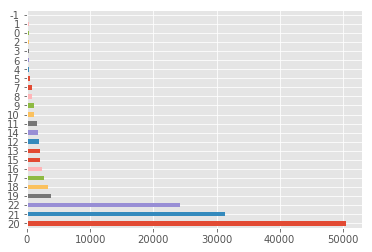

In [19]:
loan['last_credit_pull_d_since_issue'].value_counts().plot.barh()
loan['last_credit_pull_d_since_issue'].fillna(-1, inplace=True)

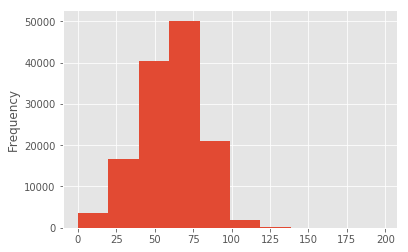

In [20]:
loan['all_util'].plot.hist()
loan['all_util'].fillna(loan['all_util'].median(), inplace=True)

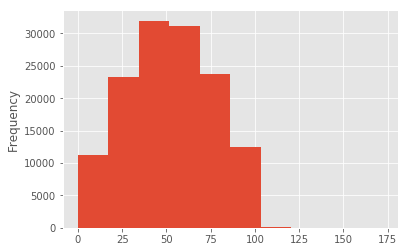

In [21]:
loan['revol_util'] = loan['revol_util'].str.replace('%','').astype(float)
loan['revol_util'].plot.hist()
loan['revol_util'].fillna(loan['revol_util'].median(), inplace=True)

In [22]:
print(loan['total_bal_il'].describe())
loan['total_bal_il'].fillna(loan['total_bal_il'].median(), inplace=True)

count    133826.000000
mean      35704.147819
std       42167.837355
min           0.000000
25%        9633.250000
50%       24144.000000
75%       46561.750000
max      796104.000000
Name: total_bal_il, dtype: float64


In [23]:
print(loan['max_bal_bc'].describe())
loan['max_bal_bc'].fillna(loan['max_bal_bc'].median(), inplace=True)

count    133826.000000
mean       6183.582271
std        6214.568114
min           0.000000
25%        2525.000000
50%        4664.000000
75%        8020.000000
max      776843.000000
Name: max_bal_bc, dtype: float64


In [24]:
loan['total_cu_tl'].fillna(0, inplace=True)
loan['open_acc_6m'].fillna(0, inplace=True)
loan['open_rv_24m'].fillna(0, inplace=True)
loan['open_rv_12m'].fillna(0, inplace=True)
loan['open_il_24m'].fillna(0, inplace=True)
loan['open_il_12m'].fillna(0, inplace=True)
loan['open_act_il'].fillna(0, inplace=True)
loan['inq_last_6mths'].fillna(0, inplace=True)
loan['inq_last_12m'].fillna(0, inplace=True)
loan['inq_fi'].fillna(0, inplace=True)

loan['title'].fillna('Other', inplace=True)
loan['next_pymnt_d_since_issue'].fillna(-1, inplace=True)
loan['last_pymnt_d_since_issue'].fillna(-1, inplace=True)

In [25]:
loan.shape

(133887, 95)

### Select numerical and categorical features

In [26]:
loan.drop(['id'], axis=1, inplace=True)

In [27]:
## numeric variables
loan['int_rate'] = loan['int_rate'].str.replace('%','').astype(float)
cols_numeric = list( (loan.describe()).columns)
print(len(cols_numeric))

for col in cols_numeric:
    loan[col] = loan[col].astype(float) 

76


### create the binary target

In [28]:
# okay: 0    past due: 1
loan['loan_status_binary'] = np.where(loan['loan_status']==('Current'or'Fully Paid'), 0, 1)
loan['loan_status_binary'].value_counts()

0    79931
1    53956
Name: loan_status_binary, dtype: int64

### use t test to select numerical variables

In [29]:
from scipy import stats

for col in cols_numeric:
    t_stat, p_value = stats.ttest_ind(loan[col],loan['loan_status_binary'], equal_var = False)
    # print(t_stat, p_value)
    if p_value > 0.05:
        cols_numeric.remove(col)
    
len(cols_numeric)

76

The t test does not help us to reduce the number of numerical features. Need to do that manually later.

#### Categorical features

In [30]:
cols_categorical = list(set(loan.columns) - set(cols_numeric))
cols_categorical

['disbursement_method',
 'earliest_cr_line_since_issue',
 'url',
 'home_ownership',
 'term',
 'zip_code',
 'debt_settlement_flag',
 'hardship_flag',
 'sub_grade',
 'initial_list_status',
 'pymnt_plan',
 'grade',
 'title',
 'verification_status',
 'issue_d',
 'purpose',
 'loan_status_binary',
 'loan_status',
 'addr_state']

In [31]:
loan.drop(['loan_status','grade','sub_grade','hardship_flag','debt_settlement_flag',
           'initial_list_status','earliest_cr_line_since_issue',
           'url','addr_state','issue_d'], axis=1, inplace=True)

In [32]:
cols_categorical = list(set(loan.columns) - set(cols_numeric))
cols_categorical

['disbursement_method',
 'home_ownership',
 'term',
 'loan_status_binary',
 'zip_code',
 'title',
 'verification_status',
 'purpose',
 'pymnt_plan']

#### collapse the feature zipcode by calculation

In [33]:
zip_bi_status = loan.groupby(['zip_code', loan['loan_status_binary']]).size().unstack()
zip_bi_status.head(2)

loan_status_binary,0,1
zip_code,,
007xx,NaN,1.0
008xx,2.0,NaN


In [34]:
zip_bi_status = zip_bi_status.reset_index()
zip_pd_rate = zip_bi_status[1]/zip_bi_status[0]
zip_pd_rate.fillna(0, axis=0, inplace=True)
zip_pd_rate.describe()

count    891.000000
mean       0.669338
std        0.305896
min        0.000000
25%        0.543031
50%        0.653846
75%        0.760384
max        4.000000
dtype: float64

In [35]:
zip_bi_status['new_zip'] = pd.qcut(zip_pd_rate, 10)
zip_bi_status['new_zip'].value_counts()

(0.654, 0.692]     91
(0.61, 0.654]      90
(0.405, 0.519]     90
(-0.001, 0.405]    90
(0.918, 4.0]       89
(0.805, 0.918]     89
(0.742, 0.805]     89
(0.563, 0.61]      89
(0.519, 0.563]     88
(0.692, 0.742]     86
Name: new_zip, dtype: int64

In [36]:
zip_bi_status.drop([0,1], axis=1, inplace=True)
zip_bi_status.head()

loan_status_binary,zip_code,new_zip
0,007xx,"(-0.001, 0.405]"
1,008xx,"(-0.001, 0.405]"
2,009xx,"(-0.001, 0.405]"
3,010xx,"(0.563, 0.61]"
4,011xx,"(0.805, 0.918]"


In [37]:
loan = pd.merge(loan, zip_bi_status, how='left', on = 'zip_code')
loan.head(2)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,home_ownership,annual_inc,verification_status,pymnt_plan,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,next_pymnt_d_since_issue,last_pymnt_d_since_issue,last_credit_pull_d_since_issue,loan_status_binary,new_zip
0,16000.0,16000.0,16000.0,36 months,5.32,481.84,RENT,105000.0,Not Verified,n,...,47543.0,23525.0,19400.0,25243.0,Cash,-1.0,2.0,8.0,1,"(0.654, 0.692]"
1,17000.0,17000.0,17000.0,36 months,9.75,546.55,MORTGAGE,40000.0,Verified,n,...,44131.0,31939.0,16300.0,27831.0,Cash,21.0,20.0,20.0,0,"(0.563, 0.61]"


In [39]:
loan.drop(['zip_code'], axis=1, inplace=True)
loan.shape

(133887, 85)

In [40]:
loan.to_csv('LoanStats_2016Q1_cleaned.csv', index=False)

## Start building models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

loan =  pd.read_csv('LoanStats_2016Q1_cleaned.csv')
loan.shape

(133887, 85)

#### Numerical features
* 'int_rate', 'installment', 'annual_inc', 'dti', 'last_pymnt_amnt', 'total_bal_il', 'revol_util', 

* 'loan_amnt', ('funded_amnt', 'funded_amnt_inv',) 

* 'total_pymnt', ('total_pymnt_inv',) 

* 'out_prncp', ('out_prncp_inv',)

* 'fico_range_low',('fico_range_high',)

* 'last_fico_range_low', ('last_fico_range_high',)

* 'inq_last_6mths', 'inq_last_12m', 

* 'open_il_12m', ('open_il_24m',) 

* 'open_rv_12m', ('open_rv_24m',) 
 
* ('total_acc',) 'open_acc','open_acc_6m', 'acc_open_past_24mths', 'open_act_il', 

* 'num_actv_bc_tl', ('num_actv_rev_tl', 'num_bc_sats',)

* 'num_bc_tl', ('num_rev_accts',)

* 'delinq_2yrs', 'delinq_amnt', 'pub_rec', 'pub_rec_bankruptcies', 'tax_liens', 'chargeoff_within_12_mths', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt','tot_cur_bal', 'avg_cur_bal', 'revol_bal', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl',  'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'num_accts_ever_120_pd', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'num_il_tl', 'num_op_rev_tl',  'num_rev_tl_bal_gt_0', 'num_sats', 'tot_hi_cred_lim', 'total_bc_limit', 'total_il_high_credit_limit', 'total_bal_ex_mort', 'next_pymnt_d_since_issue', 'last_pymnt_d_since_issue', 'last_credit_pull_d_since_issue', 

#### check the correlation and drop some features

In [2]:
cols = ['num_actv_rev_tl', 'num_bc_sats',]
np.corrcoef(loan[cols].values.T)

array([[ 1.        ,  0.68822838],
       [ 0.68822838,  1.        ]])

In [3]:
loan.drop(['funded_amnt', 'funded_amnt_inv', 'total_pymnt_inv', 'out_prncp_inv',
           'fico_range_high', 'last_fico_range_high', 'open_il_24m', 'open_rv_24m',
           'total_acc', 'num_actv_rev_tl', 'num_bc_sats', 'num_rev_accts'
          ], axis=1, inplace=True)

In [4]:
# np.log(loan['loan_amnt']).describe()
# np.log(loan['revol_bal']+1).describe()
# np.log(loan['out_prncp']+1).plot.hist()

## transform some features
loan['log_loan_amnt'] = np.log(loan['loan_amnt'])
loan['log_revol_bal'] = np.log(loan['revol_bal']+1)

#### Categorical features

In [5]:
cols_categorical = ['disbursement_method','home_ownership','term',
                    'new_zip','title','verification_status', 'purpose','pymnt_plan']

#### onehot encoding

In [6]:
X = loan.drop('loan_status_binary', axis=1)
X.shape

(133887, 74)

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [8]:
# need do label encoding for string features to int before onehot encoding
le = LabelEncoder()
for col in cols_categorical:
    le.fit(X[col])
    X[col] = le.transform(X[col])

In [9]:
X[cols_categorical].head(3)

,disbursement_method,home_ownership,term,new_zip,title,verification_status,purpose,pymnt_plan
0,0,2,0,5,4,0,2,0
1,0,0,0,3,3,2,1,0
2,0,0,1,6,7,1,3,0


In [10]:
enc = OneHotEncoder()
enc.fit(X[cols_categorical])  

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [11]:
X_cate = enc.transform(X[cols_categorical])
enc.n_values_, enc.feature_indices_

(array([ 2,  3,  2, 10, 13,  3, 12,  2]),
 array([ 0,  2,  5,  7, 17, 30, 33, 45, 47]))

In [12]:
X_num = X.drop(cols_categorical, axis=1).values
X_num.shape, X_cate.shape

((133887, 66), (133887, 47))

In [13]:
X.drop(cols_categorical, axis=1).columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'fico_range_low', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'out_prncp', 'total_pymnt',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m',
       'total_bal_il', 'open_rv_12m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0',
       'num_sats', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_o

#### create a list to record all feature names after one-hot encoding

In [14]:
cols_categorical = ['disbursement_method','home_ownership','term',
                    'new_zip','title','verification_status', 'purpose','pymnt_plan']
freq = [2, 3, 2, 10, 13, 3, 12, 2]

feature_names = []
for i in range(len(freq)):
    feature_names.append([cols_categorical[i]]*freq[i])


feature_names.append(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'fico_range_low', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'out_prncp', 'total_pymnt',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m',
       'total_bal_il', 'open_rv_12m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0',
       'num_sats', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'next_pymnt_d_since_issue',
       'last_pymnt_d_since_issue', 'last_credit_pull_d_since_issue',
       'log_loan_amnt', 'log_revol_bal'])


from functools import reduce
feature_names = reduce(lambda x,y: x+y, feature_names)
feature_names, len(feature_names)

(['disbursement_method',
  'disbursement_method',
  'home_ownership',
  'home_ownership',
  'home_ownership',
  'term',
  'term',
  'new_zip',
  'new_zip',
  'new_zip',
  'new_zip',
  'new_zip',
  'new_zip',
  'new_zip',
  'new_zip',
  'new_zip',
  'new_zip',
  'title',
  'title',
  'title',
  'title',
  'title',
  'title',
  'title',
  'title',
  'title',
  'title',
  'title',
  'title',
  'title',
  'verification_status',
  'verification_status',
  'verification_status',
  'purpose',
  'purpose',
  'purpose',
  'purpose',
  'purpose',
  'purpose',
  'purpose',
  'purpose',
  'purpose',
  'purpose',
  'purpose',
  'purpose',
  'pymnt_plan',
  'pymnt_plan',
  'loan_amnt',
  'int_rate',
  'installment',
  'annual_inc',
  'dti',
  'delinq_2yrs',
  'fico_range_low',
  'inq_last_6mths',
  'open_acc',
  'pub_rec',
  'revol_bal',
  'revol_util',
  'out_prncp',
  'total_pymnt',
  'total_rec_prncp',
  'total_rec_int',
  'total_rec_late_fee',
  'recoveries',
  'collection_recovery_fee',
  'last

In [15]:
from scipy.sparse import hstack
X_new = hstack((X_cate, X_num))
X_new.shape

(133887, 113)

#### split data into training and test datasets

In [16]:
from sklearn.model_selection import train_test_split

y = loan['loan_status_binary'].values
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

In [17]:
# define function to perform train, test, and get model performance
def train_test_model(clf, X_train, y_train, X_test, y_test):
    # Fit a model by providing X and y from training set
    clf.fit(X_train, y_train)

    # Make prediction on the training data
    y_train_pred = clf.predict(X_train)
    p_train_pred = clf.predict_proba(X_train)[:,1]

    # Make predictions on test data
    y_test_pred = clf.predict(X_test)
    p_test_pred = clf.predict_proba(X_test)[:,1]

    # print model results
    get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred)
    plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)
    

    
import pandas as pd
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

# Helper method to print metric scores    
def get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred, threshold=0.5):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
    
    metric_values_train = [roc_auc_score(y_train, y_train_pred),
                    accuracy_score(y_train, y_train_pred > threshold),
                    precision_score(y_train, y_train_pred > threshold),
                    recall_score(y_train, y_train_pred > threshold),
                    f1_score(y_train, y_train_pred > threshold)]
    
    metric_values_test = [roc_auc_score(y_test, y_test_pred),
                    accuracy_score(y_test, y_test_pred > threshold),
                    precision_score(y_test, y_test_pred > threshold),
                    recall_score(y_test, y_test_pred > threshold),
                    f1_score(y_test, y_test_pred > threshold)]
    
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},
                               columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)
    
    
    

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline

def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

### Build a Logistic Regression Classifier

              train      test
metrics                      
AUC        0.994611  0.994743
Accuracy   0.983835  0.984490
Precision  0.996027  0.996501
Recall     0.963685  0.965005
f1-score   0.979589  0.980500


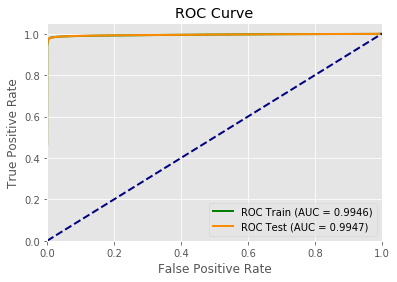

In [18]:
from sklearn.linear_model import LogisticRegression

logis = LogisticRegression(C=0.2, penalty='l1')
train_test_model(logis, X_train, y_train, X_test, y_test)

Text(0.5,0,'Feature Indice')

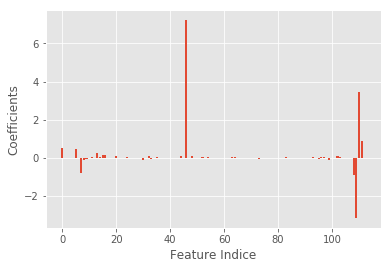

In [19]:
plt.bar(np.arange(len(logis.coef_[0])), 
        logis.coef_.flatten())
plt.ylabel('Coefficients')
plt.xlabel('Feature Indice')

In [20]:
# top 10 indices of the features
print(np.sort(logis.coef_.flatten())[::-1][:10])
[feature_names[i] for i in np.argsort(logis.coef_.flatten())[::-1][:10]]

[ 7.21171913  3.45290556  0.89957613  0.51002345  0.46104471  0.22625557
  0.16037451  0.15541605  0.11857504  0.08894334]


['pymnt_plan',
 'last_credit_pull_d_since_issue',
 'log_loan_amnt',
 'disbursement_method',
 'term',
 'new_zip',
 'new_zip',
 'new_zip',
 'purpose',
 'pub_rec_bankruptcies']

### Build a Random Forest Classifier

              train      test
metrics                      
AUC        0.999961  0.996116
Accuracy   0.988487  0.984067
Precision  0.998422  0.997892
Recall     0.972936  0.962602
f1-score   0.985514  0.979930


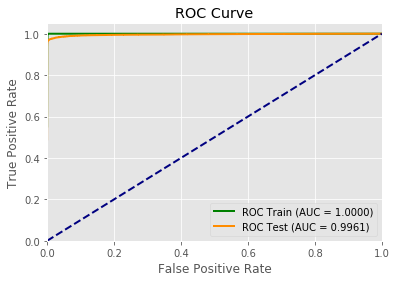

In [21]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200,
                                   max_depth=30,
                                   min_samples_leaf=3, 
                                   min_samples_split=5,
                                   random_state=42)

train_test_model(rfc, X_train, y_train, X_test, y_test)

Text(0.5,0,'Feature Indice')

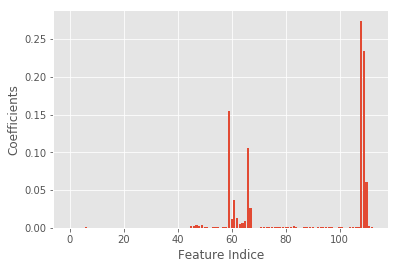

In [22]:
plt.bar(np.arange(len(rfc.feature_importances_)), 
        rfc.feature_importances_.flatten())
plt.ylabel('Coefficients')
plt.xlabel('Feature Indice')

In [24]:
# top 10 indices of the features
print(np.sort(rfc.feature_importances_)[::-1][:10])
[feature_names[i] for i in np.argsort(rfc.feature_importances_)[::-1][:10]]

[ 0.27428036  0.23451562  0.15504442  0.10601232  0.0607016   0.03716934
  0.02647464  0.01319035  0.01228895  0.00928086]


['next_pymnt_d_since_issue',
 'last_pymnt_d_since_issue',
 'out_prncp',
 'last_pymnt_amnt',
 'last_credit_pull_d_since_issue',
 'total_rec_prncp',
 'last_fico_range_low',
 'total_rec_int',
 'total_pymnt',
 'collection_recovery_fee']